In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize

Drive mount from my personal driver

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Wav* to spectrogram

# TETS EDITED HERE

File: 4666.wav, Frequency Bins: 129, Time Steps: 267


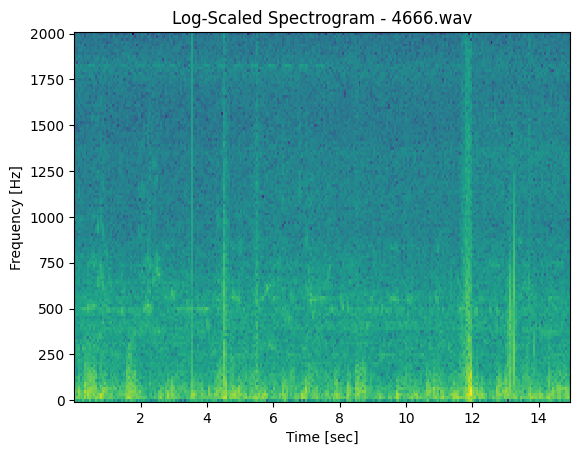

nperseg: 448 noverlap: 181
File: 4666.wav, Spectrogram shape: (224, 224)


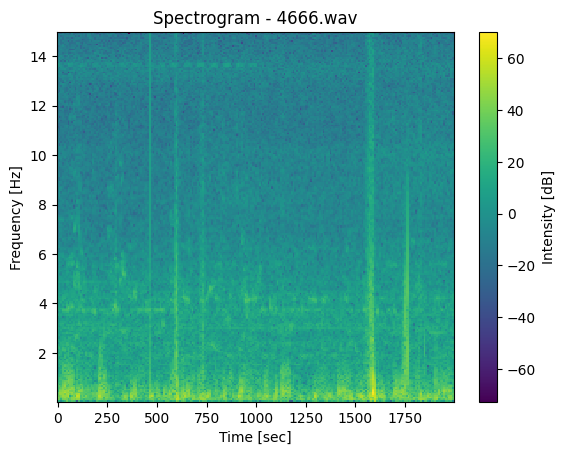

(7809, 1, 224, 224)


In [11]:
# Specify the folder path
folder_path = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/'
test = folder_path + 'train2'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(test) if f.endswith('.wav')]

# List to store all log_spectrograms for each method
all_spectrograms_1 = []
all_spectrograms_2 = []


# Original method from Masaomi
def method1():
  # Iterate through each .wav file in the folder
  for wav_file in file_list:
      # Construct the full path to the .wav file
      wav_file_path = os.path.join(test, wav_file)

      # Read the content of the .wav file
      sample_rate, samples = wavfile.read(wav_file_path)

      # Compute the spectrogram
      frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

      # NEW: obtain the dimensions of the spectrogram
      num_freq_bins = spectrogram.shape[0]
      num_time_steps = spectrogram.shape[1]

      # Apply logarithmic transformation
      log_spectrogram = 10 * np.log10(spectrogram+1e-10)

      # Store the log_spectrogram in the list
      all_spectrograms_1.append(log_spectrogram)

  # Print the first data point for the first file
  print(f"File: {file_list[0]}, Frequency Bins: {num_freq_bins}, Time Steps: {num_time_steps}")

  # Plot the log-scaled spectrogram for the first file
  plt.pcolormesh(times, frequencies, all_spectrograms_1[0], shading='auto')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.title(f'Log-Scaled Spectrogram - {file_list[0]}')
  plt.show()

method1()


def calculate_noverlap():
  steth_sample_rate = 4000
  duration = 15
  total_samples = steth_sample_rate * duration
  num_freq_bins = 224
  num_time_steps = 224

  nperseg = 2 * num_freq_bins  # (Nyquist limit)

  # num_time_steps = (total samples - noverlap) / (nperseg - noverlap)
  # t = s - o / p - o
  # tp - to = s - o
  # o = (tp - s) / (t - 1)

  noverlap = round((num_time_steps * nperseg - total_samples) / (num_time_steps - 1))
  return int(nperseg), int(noverlap)

nperseg, noverlap = calculate_noverlap()
print("nperseg:", nperseg, "noverlap:", noverlap)

def plot_spectrogram(nperseg, noverlap):
    # Iterate through each .wav file in the folder
    for wav_file in file_list:
        # Construct the full path to the .wav file
        wav_file_path = os.path.join(test, wav_file)

        # Read the WAV file
        sample_rate, samples = wavfile.read(wav_file_path)

        # Compute the spectrogram
        frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

        # Apply logarithmic transformation
        log_spectrogram = resize(10 * np.log10(spectrogram+1e-10),(224,224))

        # Store the log_spectrogram in the list
        all_spectrograms_2.append(log_spectrogram)

    # Print the shape of the first spectrogram
    print(f"File: {file_list[0]}, Spectrogram shape: {all_spectrograms_2[0].shape}")

    # Ensure X has shape (225, 224) and Y has shape (224, 225)
    X, Y = np.meshgrid(times[:225], frequencies[:224], indexing='ij')

    #print(f"Original Spectrogram shape: {spectrogram.shape}")
    #print(f"Resized Spectrogram shape: {all_spectrograms[0].shape}")
    #print(f"X shape: {X.shape}")
    #print(f"Y shape: {Y.shape}")
    

    # Plot the first spectrogram
    plt.pcolormesh(Y, X, all_spectrograms_2[0], shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram - {file_list[0]}')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Plot the spectrogram with calculated nperseg and noverlap
plot_spectrogram(nperseg, noverlap)

all_resized_spectrograms = np.reshape(np.array(all_spectrograms_2), newshape=(7809,1,224,224))

print(all_resized_spectrograms.shape)

ReSize 129x267 Reshape to VGG16 size of 224 × 224

In [8]:
# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms = []

# Iterate through each log_spectrogram
for log_spectrogram in all_spectrograms_1:
    # Resize the log_spectrogram to the target size
    resized_log_spectrogram = resize(log_spectrogram, target_size, anti_aliasing=True)

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms.append(resized_log_spectrogram)

print(np.array(all_resized_spectrograms).shape)
all_resized_spectrograms = np.reshape(np.array(all_resized_spectrograms), newshape=(7809,1,224,224))

(7809, 224, 224)


Test datasets .wav

In [ ]:
# Specify the folder path
#folder_path1 = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Test_Datasets'
folder_path1 ='G:\My Drive\Colab_Notebooks\Project_Datasets\Test_Datasets'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if f.endswith('.wav')]

# List to store all log_spectrograms
all_spectrograms = []

# Iterate through each .wav file in the folder
for wav_file in file_list:
    # Construct the full path to the .wav file
    wav_file_path = os.path.join(folder_path1, wav_file)

    # Read the content of the .wav file
    sample_rate, samples = wavfile.read(wav_file_path)

    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    # Apply logarithmic transformation
    log_spectrogram = 10 * np.log10(spectrogram)

    # Store the log_spectrogram in the list
    all_spectrograms.append(log_spectrogram)

# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms1 = []

# Iterate through each log_spectrogram
for log_spectrogram in all_spectrograms:
    # Resize the log_spectrogram to the target size
    resized_log_spectrogram = resize(log_spectrogram, target_size, anti_aliasing=True)

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms1.append(resized_log_spectrogram)

all_resized_spectrograms1 = np.reshape(np.array(all_resized_spectrograms1), newshape=(1956,1,224,224))

Train datasets Label Reader Mulit Hot Incoder


In [ ]:
# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi', 'Crackles']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices = np.array([item['vector'] for item in all_multi_hot_matrices])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices)}")


Test_datasets Label Reader Mulit Hot Incoder

In [ ]:
# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi', 'Crackles']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices1 = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path1, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector1 = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector1.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices1.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector1
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices1 = np.array([item['vector'] for item in all_multi_hot_matrices1])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices1:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices1)}")

CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label

In [ ]:
batch_size = 1
train_dataset = CustomDataset(all_resized_spectrograms,multi_hot_matrices)

test_dataset = CustomDataset(all_resized_spectrograms1,multi_hot_matrices1)

trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)

testloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1956)

 VGG16 CNN as feature extractors



In [ ]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 4)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

Check for GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

Testing VGG16 CNN shape size

In [ ]:
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True)
output = model(torch.ones(size=(1,1,224,224)))
# More infor on VGG16 (https://builtin.com/machine-learning/vgg16)

In [ ]:
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

Training VGG16 CNN

In [ ]:
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),weight_decay=1e-5)
n_epoch   = 1
n_batches = len(trainloader)
print_every = 10

loss_hist = np.zeros(n_epoch*n_batches)
acc_hist  = np.zeros(n_epoch*n_batches)

it = 0
for epoch in range(n_epoch):  # loop over the dataset multiple times

    loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # save loss
        loss_hist[it] = loss.item()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        acc_hist[it] = 100.0*np.sum(predicted.cpu().numpy() == np.argmax(labels.numpy(), axis=1))/labels.size(0)

        if (i+1) % print_every == 0:    # print every 50 mini-batches
            #vacc_hist[iter//print_every] = find_vacc(net,testloader)
            print('epoch = {}/{}, minibatch = {}/{}, loss = {}, accuracy = {}'.format(epoch+1, n_epoch, i+1, n_batches, loss.item(), acc_hist[it]))

        it+=1

print('Finished Training')

Plotting training losses

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_hist, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()


axs[1].plot(acc_hist, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()

Save the variable of training model for reusing purpose

In [ ]:
# Save all relevant information at the end of training
#Store_variable = {
 #   'model_state_dict': model.state_dict(),
 #   'optimizer_state_dict': optimizer.state_dict(),
 #   'loss_history': loss_hist,
 #   'accuracy_history': acc_hist,
 #   'train_dataset' : train_dataset,
 #   'test_dataset' : test_dataset,
 #   'trainloader' : trainloader,
 #   'testloader' : testloader,
#}

# Save the model to a file
torch.save({model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_hist,
    'accuracy_history': acc_hist,
    'train_dataset' : train_dataset,
    'test_dataset' : test_dataset,
    'trainloader' : trainloader,
    'testloader' : testloader}, )
# Create a download link link from Jupyter Notebook
from IPython.display import FileLink
FileLink(Store_variable)

# Load the model from the file
model, optimizer, loss_history, accuracy_history, train_dataset,test_dataset,trainloader,testloader = torch.load(Store_variable).values()

Testing

In [ ]:
# Find accuracy over tasting set

def find_vacc(net,loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += np.sum(predicted.cpu().numpy() == np.argmax(labels.numpy(), axis=1))
    vacc = 100.0 * correct / total
    return vacc

test_acc = find_vacc(model, testloader)

print(f'Accuracy of the network trained on the test images: {test_acc} %')